In [128]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML  # type: ignore
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv

# Import utility functions from custom modules
import utils.display as matrix_utils
import utils.plot as plot_utils
import utils.signals as signals_utils

importlib.reload(plot_utils)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
plot_utils.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 75

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


In [129]:
def get_A(p, params):
  A11 = 0
  A12 = 1
  A21 = -1
  A22 = 1 - p[0]

  return np.array([[A11, A12],
                   [A21, A22]])


def get_B(p, params):
  B11 = 0.
  B21 = 1.
  return np.array([[B11],
                   [B21]])


def get_E(p, params):
  E11 = 0.
  E21 = 1.
  return np.array([[E11],
                   [E21]])


def get_C(p, params):
  return np.array([[0., 1.]])

In [130]:
from scipy.optimize import *
import math


def find_extrema_multivar(expression, bounds, variables):
  # Ambiente seguro para avaliação da expressão, incluindo funções trigonométricas do módulo math
  environment = {k: getattr(math, k)
                 for k in dir(math) if not k.startswith("__")}

  # Definindo a função a ser minimizada
  def fun(var_values):
    local_env = {var: val for var, val in zip(variables, var_values)}
    try:
      return eval(expression, {"__builtins__": None}, {**local_env, **environment})
    except ZeroDivisionError:
      return float('inf')  # Retorna infinito se houver divisão por zero

  # Convertendo os limites do dicionário para uma lista de tuplas
  bounds_list = [bounds[var] for var in variables]

  # Definindo um ponto inicial no meio do intervalo para cada variável
  x0 = [(b[0] + b[1]) / 2 for b in bounds_list]

  # Encontrando o valor mínimo usando o método 'Powell'
  min_result = minimize(fun, x0=x0, bounds=bounds_list, method='Powell')
  if not min_result.success:
    raise ValueError("Minimization did not converge")
  min_value = min_result.fun
  min_point = min_result.x

  # Encontrando o valor máximo (minimizando o negativo da função) usando o método 'Powell'
  max_result = minimize(lambda var_values: -fun(var_values),
                        x0=x0, bounds=bounds_list, method='Powell')
  if not max_result.success:
    raise ValueError("Maximization did not converge")
  max_value = -max_result.fun
  max_point = max_result.x

  return min_value, max_value

In [131]:
def sign(n):
  if n > 0.:
    return 1.
  elif n < 0.:
    return -1.
  return 0.


def sat(u, u_bar):
  return sign(u) * min(u_bar, abs(u))


def plant_update(time, states, inputs, params):

  n_u = params['amounts']['u']
  # n_p = params['amounts']['p']
  n_w = params['amounts']['w']

  u = inputs[0:n_u].reshape(-1, 1)
  w = inputs[n_u:n_u + n_w].reshape(-1, 1)
  # w = inputs[n_u + n_p:n_u + n_p + n_w].reshape(-1, 1)

  x = states.reshape(-1, 1)

  p1 = x[0][0] ** 2
  p = [p1]

  A = get_A(p, params)
  B = get_B(p, params)
  E = get_E(p, params)

  x_dot = A @ x + B @ u + E @ w

  return x_dot


def plant_output(time, states, inputs, params):
  p1 = states[0] ** 2
  return [states[0], states[1], p1]


# Criação do Dicionário de Parâmetros
params = {
    "amounts": {'x': 2, 'p': 1, 'u': 1, 'w': 1},
}

states = [f'x{i+1}' for i in range(params["amounts"]['x'])]
inputs = ([f'u{i+1}' for i in range(params["amounts"]['u'])] +
          # [f'p{i+1}' for i in range(params["amounts"]['p'])] +
          [f'w{i+1}' for i in range(params["amounts"]['w'])])
outputs = states + [f'p{i+1}' for i in range(params["amounts"]['p'])]

plant = ct.nlsys(plant_update, plant_output, name="plant",
                 inputs=inputs, outputs=outputs, states=states)

print(plant)

<NonlinearIOSystem>: plant
Inputs (2): ['u1', 'w1']
Outputs (3): ['x1', 'x2', 'p1']
States (2): ['x1', 'x2']

Update: <function plant_update at 0x7a380f8cb4c0>
Output: <function plant_output at 0x7a380f8cad40>


∫|w(t)|dt =  0.7941735593835813


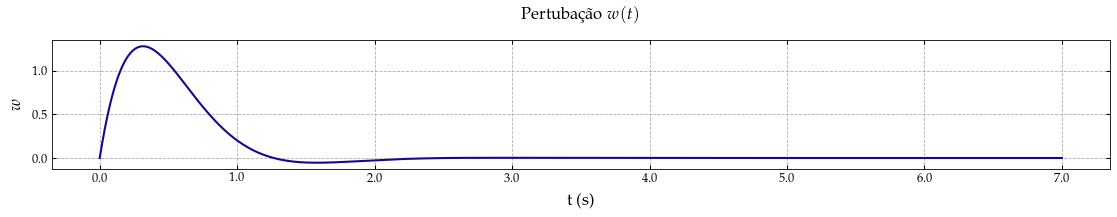

In [132]:
simulation_step = 1e-5
simulation_time = 7.
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# Entrada para simulação em malha aberta
u = np.zeros((1, len(timepts)))
# w = np.zeros((1, len(timepts)))
w = 4. * np.exp(-2.5 * timepts) * np.sin(0.79 * np.pi * timepts)

integral_w_norm = np.sum(w**2) * (timepts[1] - timepts[0])
print('∫|w(t)|dt = ', integral_w_norm)


x1_bounds = [-2., 2.]
x2_bounds = [-2., 2.]

p1_min, p1_max = find_extrema_multivar(
    f'x1 ** 2',
    bounds={'x1': (x2_bounds[0], x2_bounds[1])},
    variables=['x1']
)

p_bounds = np.array([[p1_min, p1_max]])

u_bar = [1.]

fig, axs = plt.subplot_mosaic([['w']], figsize=(15, 3))
plt.subplots_adjust(wspace=0.25, hspace=.7)


plot_utils.set_subplot(
    axs['w'],
    timepts, w.reshape(-1, 1),
    't (s)',
    '$w$',
    'Pertubação $w(t)$',
)

plt.tight_layout()

In [133]:
t, y = ct.input_output_response(
    sys=plant, T=timepts,
    U=[u, w,],
    X0=[-1., -1.],
    params=params
)

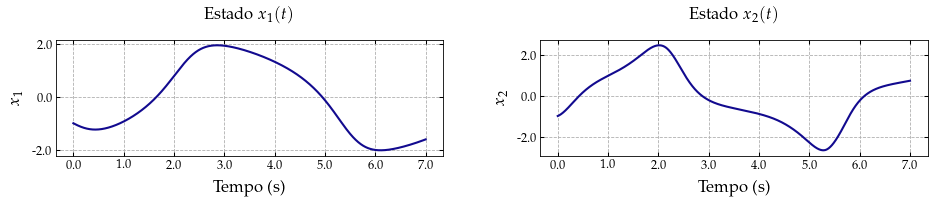

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(15, 2))
plt.subplots_adjust(wspace=0.25, hspace=.7)

plot_utils.set_subplot(
    axs[0],
    t, y[0],
    'Tempo (s)',
    '$x_1$',
    'Estado $x_1(t)$',
)

plot_utils.set_subplot(
    axs[1],
    t, y[1],
    'Tempo (s)',
    '$x_2$',
    'Estado $x_2(t)$',
)

In [135]:
def generate_binary_pairs(p):
  r = 2 ** p
  elements = list(range(r))
  result = []

  for i in elements:
    bin_i = tuple(map(int, f"{i:0{p}b}"))
    result.append([(bin_i, bin_i)])
    for j in elements:
      if i < j:
        bin_j = tuple(map(int, f"{j:0{p}b}"))
        result.append([(bin_i, bin_j), (bin_j, bin_i)])

  return result

In [136]:
def He(M): return M + M.T


def get_parameter(h, λ, delta, epsilon_bounds, eps=1e-6):

  n_u = params['amounts']['u']
  n_p = params['amounts']['p']
  n_x = params['amounts']['x']
  n_w = params['amounts']['w']
  n_z = 1

  Bnp = list(itertools.product([0, 1], repeat=n_p))
  Onx = np.zeros((n_x, n_x))
  Onxz = np.zeros((n_x, n_z))
  O2nx = np.zeros((2 * n_x, 2 * n_x))

  v1 = np.array([[1., 0.]])
  v2 = np.array([[0., 1.]])

  a = {}
  a[0] = (1. / x1_bounds[1]) * v1.T
  a[1] = - (1. / x1_bounds[0]) * v1.T
  a[2] = (1. / x2_bounds[1]) * v2.T
  a[3] = - (1. / x2_bounds[0]) * v2.T

  A = {}
  B = {}
  C = {}
  E = {}

  for i in Bnp:
    pi = [p_bounds[idx][i[idx]] for idx in range(n_p)]
    A[i] = cp.Parameter((n_x, n_x), name=f'A[{i}]', value=get_A(pi, params))
    B[i] = cp.Parameter((n_x, n_u), name=f'B[{i}]', value=get_B(pi, params))
    C[i] = cp.Parameter((n_z, n_x), name=f'C[{i}]', value=get_C(pi, params))
    E[i] = cp.Parameter((n_x, n_w), name=f'E[{i}]', value=get_E(pi, params))

  e = {}
  _es = np.eye(n_x)
  _ef = np.zeros((n_x, 6 * n_x))
  e[1] = np.block([[_es, _ef, np.zeros((n_x, n_u + n_w))]])
  e[7] = np.block([[_ef, _es, np.zeros((n_x, n_u + n_w))]])

  for i in range(2, 7):
    e[i] = np.block([[np.zeros((n_x, n_x * (i - 1))),
                      np.eye(n_x),
                      np.zeros((n_x, n_x * (7 - i))),
                      np.zeros((n_x, n_u + n_w))]])

  e[8] = np.block(
      [[np.zeros((n_u,  7 * n_x)), np.eye(n_u), np.zeros((n_u, n_w))]])
  e[9] = np.block(
      [[np.zeros((n_w,  7 * n_x)), np.zeros((n_w, n_u)), np.eye(n_w)]])

  for i in range(1, 10):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Stil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((n_x, n_x))

  Po = cp.Variable((n_x, n_x), PSD=True)

  Pcal = cp.bmat([[Ptil,   Mtil],
                  [Mtil.T, Stil]])

  constraints = []

  Ktil = {}
  Gcal = {}
  ℵ = {}

  for i in Bnp:
    Ktil[i] = cp.Variable((n_u, n_x), name=f'K[{i}]')
    Gcal[i] = cp.Variable((n_u, n_x))
    ℵ[i] = cp.Variable((n_u, n_u), diag=True)
    constraints += [ℵ[i] >> 0]

  Qtil = cp.Variable((n_x, n_x), PSD=True)
  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)
  β = cp.Variable(pos=True)
  γ = cp.Variable(pos=True)
  δ = cp.Parameter(pos=True, value=delta)
  ρ = cp.Variable(pos=True)

  X = cp.Variable((n_x, n_x))
  Nw = cp.Variable((1, 1))
  Y1til = cp.Variable((2 * n_x, 2 * n_x))
  Y2til = cp.Variable((2 * n_x, 2 * n_x))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  N = e[1].T + λ * e[2].T + λ * e[3].T

  Π = cp.bmat([[e[1] - e[3]],
              [e[1] + e[3] - 2 * e[5]],
              [e[3] - e[4]],
              [e[3] + e[4] - 2 * e[6]]])

  κ1 = {}
  κ1['0'] = cp.bmat([[e[1]], [h * e[6]]])
  κ1['h'] = cp.bmat([[e[1]], [h * e[5]]])

  κ2 = cp.bmat([[e[2]], [e[1] - e[4]]])

  def get_Λ(i, j):
    Ytil = A[i] @ X @ e[1] - X @ e[2] + \
        B[i] @ Ktil[j] @ e[3] + B[i] @ Ktil[j] @ e[7] - \
        B[i] @ ℵ[j] @ e[8] + γ * E[i] @ e[9]

    Φtil = {}

    Φtil1 = cp.bmat([[Rcal, O2nx],
                    [O2nx, Rcal]])
    Φtil2 = cp.bmat([[Rcal, Y2til], [Y2til.T, O2nx]])
    Φtil3 = cp.bmat([[O2nx, Y1til], [Y1til.T, Rcal]])

    Φtil['0'] = Φtil1 + Φtil2
    Φtil['h'] = Φtil1 + Φtil3

    Θtil = {}
    Θtil['0'] = 2 * κ1['0'].T @ Pcal @ κ2 + h * e[1].T @ Qtil @ e[1] - \
        h * e[4].T @ Qtil @ e[4] + (h ** 2) * e[2].T @ Rtil @ e[2] - \
        e[7].T @ Ξtil @ e[7] + He(N @ Ytil) - γ * e[9].T @ e[9] - \
        2. * e[8].T @ ℵ[j] @ e[8] + 2. * \
        e[8].T @ Gcal[j] @ e[3] + 2. * \
        e[8].T @ Gcal[j] @ e[7] - Π.T @ Φtil['0'] @ Π

    Θtil['h'] = 2 * κ1['h'].T @ Pcal @ κ2 + h * e[1].T @ Qtil @ e[1] - \
        h * e[4].T @ Qtil @ e[4] + (h ** 2) * e[2].T @ Rtil @ e[2] - \
        e[7].T @ Ξtil @ e[7] + He(N @ Ytil) - γ * e[9].T @ e[9] - \
        2. * e[8].T @ ℵ[j] @ e[8] + 2. * \
        e[8].T @ Gcal[j] @ e[3] + 2. * \
        e[8].T @ Gcal[j] @ e[7] - Π.T @ Φtil['h'] @ Π

    Γ1_11 = Θtil['0'] - Π.T @ Φtil['0'] @ Π
    Γ1_12 = Π.T @ cp.bmat([[Y1til], [O2nx]])
    Γ1_13 = e[3].T @ X.T
    Γ1_14 = e[1].T @ X.T @ C[i].T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Rcal
    Γ1_23 = np.zeros((2 * n_x, n_x))
    Γ1_24 = np.zeros((2 * n_x, n_z))

    Γ1_31 = Γ1_13.T
    Γ1_32 = Γ1_23.T
    Γ1_33 = - Ψtil
    Γ1_34 = np.zeros((n_x, n_z))

    Γ1_41 = Γ1_14.T
    Γ1_42 = Γ1_24.T
    Γ1_43 = Γ1_34.T
    Γ1_44 = - np.eye(n_z)

    Γ1 = cp.bmat([[Γ1_11, Γ1_12, Γ1_13, Γ1_14],
                  [Γ1_21, Γ1_22, Γ1_23, Γ1_24],
                  [Γ1_31, Γ1_32, Γ1_33, Γ1_34],
                  [Γ1_41, Γ1_42, Γ1_43, Γ1_44]])

    Γ2_11 = Θtil['h'] - Π.T @ Φtil['h'] @ Π
    Γ2_12 = Π.T @ cp.bmat([[O2nx], [Y2til.T]])
    Γ2_13 = e[3].T @ X.T
    Γ2_14 = e[1].T @ X.T @ C[i].T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))
    Γ2_24 = np.zeros((2 * n_x, n_z))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil
    Γ2_34 = np.zeros((n_x, n_z))

    Γ2_41 = Γ2_14.T
    Γ2_42 = Γ2_24.T
    Γ2_43 = Γ2_34.T
    Γ2_44 = - np.eye(n_z)

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13, Γ2_14],
                  [Γ2_21, Γ2_22, Γ2_23, Γ2_24],
                  [Γ2_31, Γ2_32, Γ2_33, Γ2_34],
                  [Γ2_41, Γ2_42, Γ2_43, Γ2_44]])

    return Γ1, Γ2

  # for i in Bnp:
  #   for j in Bnp:
  #     LMI1 = {}
  #     LMI1['0'], LMI1['h'] = get_Λ(i, j)
  #     constraints += [LMI1['0'] << 0, LMI1['h']
  #                     << -eps * np.eye(LMI1['0'].shape[0])]

  binary_pairs = generate_binary_pairs(n_p)

  for pairs in binary_pairs:
    LMI_SUM = {}
    LMI_SUM['0'], LMI_SUM['h'] = 0., 0.

    for pair in pairs:
      Λ = {}
      Λ['0'], Λ['h'] = get_Λ(pair[0], pair[1])
      LMI_SUM['0'] += Λ['0']
      LMI_SUM['h'] += Λ['h']

    constraints += [LMI_SUM['0'] << -eps * np.eye(LMI_SUM['0'].shape[0])]
    constraints += [LMI_SUM['h'] << -eps * np.eye(LMI_SUM['0'].shape[0])]

  v = {}
  v[1] = np.block([[np.eye(2 * n_x), np.zeros((2 * n_x, n_x))]])
  v[2] = np.block([[np.zeros((n_x, 2 * n_x)), np.eye(n_x)]])

  for ell in range(n_u):
    for j in Bnp:
      LMISAT_11 = Ptil + (h ** 2) * Stil + h * (Qtil + Mtil + Mtil.T)
      LMISAT_12 = (Ktil[j][ell:ell+1] - Gcal[j][ell:ell+1]).T
      LMISAT_13 = (Ktil[j][ell:ell+1] - Gcal[j][ell:ell+1]).T

      LMISAT_21 = LMISAT_12.T
      LMISAT_22 = β * (u_bar[ell] ** 2) * np.eye(1)
      LMISAT_23 = np.zeros((1, 1))

      LMISAT_31 = LMISAT_13.T
      LMISAT_32 = LMISAT_23.T
      LMISAT_33 = γ * δ * (u_bar[ell] ** 2) * np.eye(1)

      LMISAT = cp.bmat([[LMISAT_11, LMISAT_12, LMISAT_13],
                        [LMISAT_21, LMISAT_22, LMISAT_23],
                        [LMISAT_31, LMISAT_32, LMISAT_33]])

      constraints += [LMISAT >> 0.]

      # Deixar >= resulta em infactibilidades

  for i in range(4):
    LMI_XCAL_11 = β * np.eye(1)
    LMI_XCAL_12 = ρ * a[i].T
    LMI_XCAL_21 = LMI_XCAL_12.T
    LMI_XCAL_22 = X.T + X - Ptil

    LMI_XCAL = cp.bmat([[LMI_XCAL_11, LMI_XCAL_12],
                        [LMI_XCAL_21, LMI_XCAL_22]])

    constraints += [LMI_XCAL >> 0.]
    # Deixar >= resulta em infactibilidades

  constraints += [Pcal >> 0.]
  # constraints += [Pcal >> eps * np.eye(2 * n_x)]

  # X está sendo limitado a fim de evitar problemas numéricos
  # constraints += [X >= 1e-6 * np.eye(n_x)]

  constraints += [(h ** 2) * Stil + h * (Qtil + Mtil + Mtil.T)
                  << - eps * np.eye(Stil.shape[0])]

  constraints += [γ >= epsilon_bounds[0]]
  constraints += [ρ >= epsilon_bounds[1]]

  obj = cp.Minimize(cp.trace(Ξtil + Ψtil) + β)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    # print("Optimal value: %s\n" % prob.value)

    # matrix_utils.show_matrix(Ξtil.value, 'Ξtil')

    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)

    # matrix_utils.show_matrix(Xinv.T @ Ξtil.value)

    # matrix_utils.show_matrix(X.value, 'X')

    P = Xinv.T @ Ptil.value @ Xinv
    M = Xinv.T @ Mtil.value @ Xinv
    S = Xinv.T @ Stil.value @ Xinv
    Q = Xinv.T @ Qtil.value @ Xinv
    R = Xinv.T @ Rtil.value @ Xinv

    Pcal_ = np.block([[P, M], [M.T, S]])

    # matrix_utils.show_matrix(Ptil.value, 'Ptil')

    P_eig = np.linalg.eig(P)[0]
    S_eig = np.linalg.eig(S)[0]
    Pcal_eig = np.linalg.eig(Pcal_)[0]

    error = False

    for i in range(n_x):
      if P_eig[i] <= 0:
        # print("P não é definida positiva!")
        error = True
      if S_eig[i] <= 0:
        # print("S não é definida positiva!")
        error = True

    # print('Autovalores de Pcal: ', Pcal_eig)
    for eig in Pcal_eig:
      if eig <= 0:
        # print("Pcal não é definida positiva!")
        error = True

    if error == False:
      K = {}
      G = {}
      for i in Bnp:
        K[i] = Ktil[i].value @ Xinv
        G[i] = Gcal[i].value @ Xinv
        # matrix_utils.show_matrix(K[i], f'K{i}')

      # matrix_utils.show_matrix(Ξ, 'Ξ')
      # matrix_utils.show_matrix(Ψ, 'Ψ')
      ans = (h ** 2) * Stil.value + h * \
          (Qtil.value + Mtil.value + Mtil.T.value)
      matrix_utils.show_matrix(ans, 'Teste')
      print(np.linalg.eig(ans)[0])

      design_results = {
          'optimal_value': prob.value,
          'etm': {'Ξ': Ξ, 'Ψ': Ψ},
          'controller': {'K': K, 'G': G},
          'lyapunov': {'P': P, 'M': M, 'S': S, 'Q': Q, 'R': R},
          'bounds': {'γ': γ.value, 'β': β.value, 'ρ': ρ.value}
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [137]:
%%skip

import numpy as np
import concurrent.futures

# Definir a escala logarítmica dos parâmetros
ε1_values = np.logspace(-6, -1, num=150)  # Epsilon de γ
ε2_values = np.logspace(-6, -1, num=150)  # Epsilon de ρ

δ = 0.2
h = 10e-3
λ = 1e-2

# Lista para armazenar os resultados
opt_prob_results = []

# Função para executar no pool de processos


def evaluate_parameters(args):
  ε1, ε2 = args
  try:
    epsilon_bounds = [ε1, ε2]
    design_results = get_parameter(h, λ, δ, epsilon_bounds)
    if design_results is not None:
      bounds = design_results['bounds']
      return (bounds['γ'], bounds['ρ'], bounds['β'], design_results['optimal_value'])
  except:
    pass
  return None


# Criando a lista de combinações dos parâmetros
param_combinations = [(ε1, ε2) for ε1 in ε1_values for ε2 in ε2_values]

# Executando em paralelo
with concurrent.futures.ProcessPoolExecutor() as executor:
  for result in executor.map(evaluate_parameters, param_combinations):
    if result is not None:
      opt_prob_results.append(result)

print(len(opt_prob_results), 'tuplas de parâmetros foram factíveis!')

In [138]:
%%skip

import numpy as np
import matplotlib.pyplot as plt

%matplotlib qt
# %matplotlib inline

# Dados
res_array = np.array(opt_prob_results)

X = res_array[:, 0]
Y = res_array[:, 1]
Z = res_array[:, 2]

# Definir os limites desejados para X e Y
x_min, x_max = 0., 0.3

# Criar uma máscara para filtrar os pontos dentro dos intervalos desejados
mask = (X >= x_min) & (X <= x_max)

# Aplicar a máscara aos dados
X_filtered = X[mask]
Y_filtered = Y[mask]
Z_filtered = Z[mask]

# Criando a figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotando os pontos filtrados
ax.scatter(X_filtered, Y_filtered, Z_filtered, c='b', marker='o')

# Definir os limites dos eixos
ax.set_xlim([x_min, x_max])
ax.set_xlabel('$\\gamma$')
ax.set_ylabel('$\\rho$')
ax.set_zlabel('$f^{\\star}$')
ax.set_title('Gráfico 3D dos pontos filtrados')

# Exibir o gráfico
plt.show()

# Exibir o gráfico
plt.tight_layout()


In [139]:
%%skip

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata


def plot_3d_surface(X_filtered, Y_filtered, Z_filtered, x_min=0., x_max=1e-1, method='linear', labels=['x', 'y', 'z']):
  """
  Função para plotar uma superfície 3D interpolada a partir dos pontos fornecidos.

  Parâmetros:
  X_filtered (array): Dados para o eixo X.
  Y_filtered (array): Dados para o eixo Y.
  Z_filtered (array): Dados para o eixo Z.
  x_min (float): Valor mínimo de X para a grade (padrão 0.0).
  x_max (float): Valor máximo de X para a grade (padrão 1e-1).
  method (str): Método de interpolação ('linear', 'nearest', 'cubic') (padrão 'linear').
  """

  # Definir os limites de X e Y para criar a grade
  y_min, y_max = np.min(Y_filtered), np.max(Y_filtered)
  x_grid, y_grid = np.meshgrid(np.linspace(
      x_min, x_max, 100), np.linspace(y_min, y_max, 100))

  # Interpolação com o método especificado
  z_grid = griddata((X_filtered, Y_filtered), Z_filtered,
                    (x_grid, y_grid), method=method)

  # Criando a figura 3D
  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')

  # Plotando a superfície
  ax.plot_surface(x_grid, y_grid, z_grid, cmap='magma')

  # Definir os limites dos eixos
  ax.set_xlim([x_min, x_max])
  ax.set_xlabel(labels[0], fontsize=20, labelpad=12)
  ax.set_ylabel(labels[1], fontsize=20, labelpad=12)
  ax.set_zlabel(labels[2], fontsize=20, labelpad=4)
  ax.grid(linestyle='--')
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=18)
  ax.xaxis.get_offset_text().set_fontsize(20)
  ax.yaxis.get_offset_text().set_fontsize(20)

  # Definir o título com o tamanho de fonte
  # ax.set_title('Superfície 3D Interpolada', fontsize=16)

  # Ajustar layout e exibir o gráfico
  plt.tight_layout()
  plt.show(block=False)

In [140]:
%%skip

%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

X = res_array[:, 0]
Y = res_array[:, 1]
Z_beta = res_array[:, 2]
Z_trace = res_array[:, 3] - res_array[:, 2]

# Definir os limites desejados para X e Y
x_min, x_max = 0., 0.3

# Criar uma máscara para filtrar os pontos dentro dos intervalos desejados
mask = (X >= x_min) & (X <= x_max)

# Aplicar a máscara aos dados
X_filtered = X[mask]
Y_filtered = Y[mask]
Z_beta_filtered = Z_beta[mask]
Z_trace_filtered = Z_trace[mask]

# Definir os limites de X e Y para criar a grade
x_min, x_max = 0., 0.1
num = 100
y_min, y_max = np.min(Y_filtered), np.max(Y_filtered)
x_grid, y_grid = np.meshgrid(
  np.linspace(x_min, x_max, num), 
  np.linspace(y_min, y_max, num))

labels_beta = ['$\\gamma$', '$\\rho$', '$\\beta$']
labels_trace = ['$\\gamma$', '$\\rho$', 'tr$(\\tilde \\Xi + \\tilde \\Psi)$']

# plot_3d_surface(X_filtered, Y_filtered, Z_beta_filtered, labels=labels_beta)
# plot_3d_surface(X_filtered, Y_filtered, Z_trace_filtered, labels=labels_trace)

In [141]:
%%skip

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri


def plot_2d_projection(X, Y, Z, x_min=None, x_max=None, levels=25, cmap='magma', labels=['X', 'Y', 'Z']):
  """
  Gera um gráfico 2D de Z em função de X e Y usando triangulação sem interpolação.

  Parâmetros:
      X : numpy.ndarray
          Array 1D contendo os valores da variável X.
      Y : numpy.ndarray
          Array 1D contendo os valores da variável Y.
      Z : numpy.ndarray
          Array 1D contendo os valores da variável Z.
      x_min : float, opcional
          Valor mínimo do intervalo de X a ser considerado (se None, usa min(X)).
      x_max : float, opcional
          Valor máximo do intervalo de X a ser considerado (se None, usa max(X)).
      levels : int, opcional
          Número de níveis nos contornos.
      cmap : str, opcional
          Mapa de cores para o gráfico (padrão: 'magma').
  """

  # Definir limites se não forem fornecidos
  if x_min is None:
    x_min = np.min(X)
  if x_max is None:
    x_max = np.max(X)

  # Filtrar os pontos dentro do intervalo desejado
  mask = (X >= x_min) & (X <= x_max)
  X_filtered, Y_filtered, Z_filtered = X[mask], Y[mask], Z[mask]

  # Verificar se há pontos suficientes para triangulação
  if len(X_filtered) < 3:
    print("Pontos insuficientes para triangulação.")
    return

  # Criar triangulação
  triang = tri.Triangulation(X_filtered, Y_filtered)

  # Criar o gráfico
  plt.figure(figsize=(6, 5))
  contour = plt.tricontourf(triang, Z_filtered, levels=levels, cmap=cmap)

  plt.xlabel(labels[0], fontsize=20, labelpad=12)
  plt.ylabel(labels[1], fontsize=20, labelpad=12)
  plt.grid(linestyle='--', c='#121212', linewidth=0.5)

  # Ajustar os ticks
  plt.tick_params(axis='both', direction='in', length=4, width=1,
                  colors='black', top=True, right=True, labelsize=18)

  # Acessar os eixos atuais para modificar os rótulos dos deslocamentos
  ax = plt.gca()
  ax.xaxis.get_offset_text().set_fontsize(24)
  ax.yaxis.get_offset_text().set_fontsize(24)

  # Barra de cores
  cbar = plt.colorbar(contour, pad=0.02)
  cbar.set_label(labels[2], fontsize=20, labelpad=12)
  cbar.ax.tick_params(labelsize=16)

  plt.tight_layout()
  plt.show()


# Definir os dados
X = res_array[:, 0]
Y = res_array[:, 1]
Z_beta = res_array[:, 2]
Z_trace = res_array[:, 3] - res_array[:, 2]

# Definir os limites desejados para X e Y
x_min, x_max = 0., 0.3

# Definir os rótulos dos gráficos
labels_beta = ['$\\gamma$', '$\\rho$', '$\\beta$']
labels_trace = ['$\\gamma$', '$\\rho$', 'tr$(\\tilde \\Xi + \\tilde \\Psi)$']

# Gerar os gráficos
plot_2d_projection(X, Y, Z_beta, x_min=x_min, x_max=x_max, labels=labels_beta)
plot_2d_projection(X, Y, Z_trace, x_min=x_min,
                   x_max=x_max, labels=labels_trace)

In [159]:

δ = 1.25
h = 10e-3
λ = 1e-2


gamma_bound = 1e-1
rho_bound = 1e-3

design_results = get_parameter(
    h=h, λ=λ, delta=δ, epsilon_bounds=[gamma_bound, rho_bound])

Ξ = None
Ψ = None
K = None
G = None
P = None
M = None
S = None
Q = None
R = None
ρ = None
γ = None
β = None

if design_results is not None:
  Ξ = design_results['etm']['Ξ']
  Ψ = design_results['etm']['Ψ']
  K = design_results['controller']['K']
  G = design_results['controller']['G']
  P = design_results['lyapunov']['P']
  M = design_results['lyapunov']['M']
  S = design_results['lyapunov']['S']
  Q = design_results['lyapunov']['Q']
  R = design_results['lyapunov']['R']
  ρ = design_results['bounds']['ρ']
  γ = design_results['bounds']['γ']
  β = design_results['bounds']['β']

  print(design_results['optimal_value'])

  # print(design_results['bounds'])
  μ_inv = (1. / β) + (1. / δ) * (1. / γ)

  print(f'Ganho induzido = %.3e' % np.sqrt(1. / γ))
  print(f'β = %.3e' % β)
  print(f'γ = %.3e' % γ)
  print(f'ρ = %.3e' % ρ)
  print(f'x.T P x <= %.3e' % (1. / β))
  print(f'V(x(t)) <= %.3e\n' % μ_inv)

  matrix_utils.show_matrix(Ξ, 'Ξ')
  matrix_utils.show_matrix(Ψ, 'Ψ')
  matrix_utils.show_matrix(P, 'P')

  B1 = list(itertools.product([0, 1], repeat=1))
  for i in B1:
    matrix_utils.show_matrix(K[i], 'K')
    matrix_utils.show_matrix(G[i], 'G')
else:
  print('Problema não é factível!')

Teste =
    ┌                      ┐
    │ -6.39e-04   2.20e-05 │
    │  2.20e-05  -1.71e-06 │
    └                      ┘

[-6.39303451e-04 -9.49466791e-07]
4.505010063234278
Ganho induzido = 3.162e+00
β = 1.678e+00
γ = 1.000e-01
ρ = 1.117e-03
x.T P x <= 5.958e-01
V(x(t)) <= 8.596e+00

Ξ =
    ┌                    ┐
    │ 4.38e+00  5.98e+01 │
    │ 5.98e+01  1.03e+03 │
    └                    ┘

Ψ =
    ┌                      ┐
    │  1.65e+00  -7.92e-03 │
    │ -7.92e-03   1.57e+00 │
    └                      ┘

P =
    ┌                    ┐
    │ 2.91e+01  1.95e+00 │
    │ 1.95e+00  5.10e+01 │
    └                    ┘

K =
    ┌                      ┐
    │ -1.60e-01  -3.15e+00 │
    └                      ┘

G =
    ┌                      ┐
    │ -1.91e-02  -7.11e-01 │
    └                      ┘

K =
    ┌                     ┐
    │ -1.96e-01  4.56e-01 │
    └                     ┘

G =
    ┌                    ┐
    │ 7.43e-04  3.25e-02 │
    └                    ┘



In [143]:
def plot_poliedro(ax, x1_bounds, x2_bounds, ρ, β, color='b'):
  """
  Plota o contorno poliedral de x1 e x2 em um eixo específico.

  Parâmetros:
  - ax: objeto de eixo (axes) do Matplotlib onde o poliedro será plotado.
  - x1_bounds: tupla (x1_min, x1_max) definindo os limites de x1.
  - x2_bounds: tupla (x2_min, x2_max) definindo os limites de x2.
  - ρ: fator multiplicador.
  - β: parâmetro usado no fator multiplicador.
  - color: cor do poliedro (opcional, padrão 'b' - azul).
  """

  # Definição dos limites
  x1_min, x1_max = x1_bounds
  x2_min, x2_max = x2_bounds

  # Fator multiplicador
  alpha = ρ * np.sqrt(1. / β)
  alpha = 1.

  # Aplicação do fator
  x1_min *= alpha
  x1_max *= alpha
  x2_min *= alpha
  x2_max *= alpha

  # Definição dos vértices do poliedro
  vertices = np.array([
      [x1_min, x2_min],
      [x1_max, x2_min],
      [x1_max, x2_max],
      [x1_min, x2_max],
      [x1_min, x2_min]  # Fechando o contorno
  ])

  # Plotando no eixo fornecido
  ax.plot(vertices[:, 0], vertices[:, 1], color+'-',
          linewidth=2, label="Contorno Poliedral")
  # ax.fill(vertices[:, 0], vertices[:, 1], color,
  #         alpha=0.2)  # Preenchimento opcional
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  ax.axhline(0, color='k', linewidth=0.5)
  ax.axvline(0, color='k', linewidth=0.5)
  ax.grid(True, linestyle='--', alpha=0.6)
  ax.legend()

In [144]:
def plot_phase_diagram(ax, P, beta, title="", x1_range=(-0.2, 0.2), x2_range=(-0.2, 0.2), num_points=100, color='black', label='${{\\cal D}_0}$'):
  eigvals = np.linalg.eigvals(P)
  max_radius = np.sqrt(beta / min(eigvals)) if min(eigvals) > 0 else 10

  x1 = np.linspace(x1_range[0], x1_range[1], num_points)
  x2 = np.linspace(x2_range[0], x2_range[1], num_points)
  X1, X2 = np.meshgrid(x1, x2)

  Z = np.zeros_like(X1)
  for i in range(num_points):
    for j in range(num_points):
      x = np.array([X1[i, j], X2[i, j]])
      Z[i, j] = x.T @ P @ x

  # ax.contourf(X1, X2, Z, levels=[0, beta], colors=['black'], alpha=0.1)
  contour = ax.contour(X1, X2, Z, levels=[beta], colors=[
                       color], linewidths=2.5)
  contour.collections[0].set_label(label)

In [145]:
def plot_V_contour(ax, P, M, S, Q, h, mu, x1_range=(-0.2, 0.2), x2_range=(-0.2, 0.2), num_points=100):
  # Geração de pontos no espaço de estados
  x1 = np.linspace(x1_range[0], x1_range[1], num_points)
  x2 = np.linspace(x2_range[0], x2_range[1], num_points)
  X1, X2 = np.meshgrid(x1, x2)

  # Função para computar \mathcal{V}(x)
  def compute_V(X1, X2):
    V_values = np.zeros_like(X1)
    for i in range(X1.shape[0]):
      for j in range(X1.shape[1]):
        x = np.array([X1[i, j], X2[i, j]])
        ξ = np.hstack((x, h * x))
        Pcal = np.block([[P, M], [M.T, S]])
        V1 = ξ.T @ Pcal @ ξ

        integral_1 = h * x.T @ Q @ x
        integral_2 = ((h ** 3) / 2.) * x.T @ R @ x

        V2 = integral_1 + integral_2
        V_values[i, j] = V1 + V2
    return V_values

  V = compute_V(X1, X2)

  # Plot do contorno
  contour = ax.contour(X1, X2, V, levels=[mu], colors='black', linestyles='--')

In [146]:
def generate_contour_points(P, beta, num_points=100):
  # Compute eigenvalues and eigenvectors of P
  eigvals, eigvecs = np.linalg.eigh(P)

  # Generate points on a unit circle
  angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
  circle_points = np.array([np.cos(angles), np.sin(angles)])

  # Scale by the square root of the eigenvalues
  ellipse_points = eigvecs @ np.diag(1 / np.sqrt(eigvals)
                                     ) @ circle_points * np.sqrt(beta)

  return ellipse_points


num_points = 20
contour_points = generate_contour_points(P, 1. / β, num_points)

In [147]:
%matplotlib qt
x1_range = (-10, 10)
x2_range = (-10, 10)


fig, ax = plt.subplots(1, 1, figsize=(6., 6.))
fig.canvas.manager.set_window_title("Região de Estabilidade Externa/Estados Iniciais Admissíveis")

plt.plot(contour_points[0], contour_points[1], '*', linestyle='None', c='black', markersize=12)
# plot_poliedro(ax, x1_bounds, x2_bounds, ρ, β, color='b')
plot_phase_diagram(
    ax, P, (1. / β),
    "Região: $x^{\\top} P x \\leq \\beta^{-1}$",
    x1_range, x2_range, num_points=200)
plot_V_contour(ax, P, M, S, Q, h, μ_inv, x1_range, x2_range)
plt.tight_layout()

In [ ]:
class DynamicETM:
  def __init__(self, name, Ψ, Ξ, θ, λ, T):
    self.name = name
    self.previous_time = 0
    self.first_simulation = True
    self.event_times = [0.]
    self.next_sampling_time = 0.
    self.last_time = 0.
    self.last_sampled_states = []
    self.last_printed_sampling_time = -1.

    # Matrizes de Acionamento
    self.Ξ = Ξ
    self.Ψ = Ψ
    self.T = T

    self.θ = θ
    self.λ = λ
    self.system = ct.NonlinearIOSystem(
        self.etm_update, self.etm_output,
        name=self.name, states=['n'],
        inputs=['x1_hat', 'x2_hat', 'x1', 'x2', 'p1_hat', 'plant_p1'],
        outputs=['n', 'x1', 'x2', 'p1']
    )

  def etm_update(self, t, n, u, params):
    # Obtenção do último estado transmitido e o estado atual
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)

    # Verifica se ocorrerá um novo evento de transmissão
    new_event = False
    is_sampling_instant = False
    if t >= self.next_sampling_time:
      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = n[0] + self.θ * Tcal < 0
      is_sampling_instant = True

    # Obtenção do x(t - τ)
    xτ = self.last_sampled_states  # Para t != nh
    if is_sampling_instant:
      xτ = x.copy()                # Para t == nh

    # Verifica a atualização de x_hat e ε
    ε = x_hat - xτ
    if new_event == True or t == 0.:
      x_hat = x.copy()
      ε = np.zeros((2, 1))

    # Atualiza a variável dinâmica
    Tcal = xτ.T @ self.Ψ @ xτ - ε.T @ self.Ξ @ ε
    n_dot = - self.λ * n + Tcal

    return n_dot

  def etm_output(self, t, n, u, params):
    if t != self.previous_time:
      if self.previous_time >= self.next_sampling_time:
        self.next_sampling_time += self.T

      if self.first_simulation and t == 0.:
        self.first_simulation = False
        self.previous_time = 0
        self.last_printed_sampling_time = -1.

      if t == 0.:
        self.last_time = 0.
        self.next_sampling_time = 0.
      elif t < self.previous_time:
        assert 'Integração Retrógrada'

      self.previous_time = t

    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)
    p_hat = u[4:5]
    p = u[5:6]

    new_event = False

    if (t >= self.next_sampling_time):
      if (t != self.last_printed_sampling_time):
        # print(f'Sampling Time: {t:.3f}')
        self.last_printed_sampling_time = t

      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = (n[0] + self.θ * Tcal < 0.) or (t == 0.)
      self.last_sampled_states = x

    if self.first_simulation and new_event and self.event_times[-1] != t:
      # print('Event Time: ', t)
      self.event_times.append(t)

    x_to_send = x if new_event else x_hat
    p_to_send = p if new_event else p_hat

    return np.concatenate((n, x_to_send.reshape(-1), p_to_send))

In [149]:

class ZeroOrderHold:
  def __init__(self):
    self.previous_time = 0
    self.previous = []
    self.last_samples_sent = [0., 0., 0.]
    self.system = ct.nlsys(
        None, self.zoh_output,
        name='zoh',
        inputs=['x1', 'x2', 'p1'],
        outputs=['x1_hat', 'x2_hat', 'p1_hat'],
    )

  def zoh_output(self, t, x, u, params):
    if t != self.previous_time:
      self.last_samples_sent = self.previous
      self.previous_time = t
    self.previous = u
    return self.last_samples_sent


class Controller:
  def __init__(self, K):
    self.K = K
    self.system = ct.nlsys(
        None, self.control_output,
        name='controller',
        inputs=['x1_hat', 'x2_hat', 'p1_hat'],
        outputs=['u1'],
    )

  def control_output(self, t, x, u, params):
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    p1_hat = u[2]

    α_1 = (p_bounds[0][1] - p1_hat) / (p_bounds[0][1] - p_bounds[0][0])
    α_0 = 1. - α_1

    u = α_1 * K[(0,)] @ x_hat + α_0 * K[(1,)] @ x_hat

    return np.array([[sat(u[0][0], u_bar[0])]])

In [150]:
import concurrent.futures
import numpy as np
import control as ct
import os
import json

# Nome do arquivo de experimento
experiment_name = "Buck-Converter.json"

# indexes = range(num_points)
indexes = [2]

# Estrutura para armazenar os resultados
results_clsim = {
    'trajectories': [],
    'inter-event-times': []
}

# Verificar se o arquivo já existe
if os.path.exists(experiment_name):
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    results_clsim = json.load(f)
else:
  def get_trajectories(i):
    υ = 1e-3
    θ = (1. / υ) * (np.exp(λ * h) - 1.)

    etm = DynamicETM('etm', Ψ, Ξ, θ, λ, h)
    zoh = ZeroOrderHold()
    controller = Controller(K)

    closed_loop = ct.interconnect(
        (plant, etm.system, zoh.system, controller.system),
        connections=[
            ['plant.u1', 'controller.u1'],

            ['etm.x1_hat', 'zoh.x1_hat'],
            ['etm.x2_hat', 'zoh.x2_hat'],
            ['etm.plant_p1', 'plant.p1'],
            ['etm.p1_hat', 'zoh.p1_hat'],

            ['etm.x1', 'plant.x1'],
            ['etm.x2', 'plant.x2'],

            ['zoh.x1', 'etm.x1'],
            ['zoh.x2', 'etm.x2'],
            ['zoh.p1', 'etm.p1'],

            ['controller.x1_hat', 'zoh.x1_hat'],
            ['controller.x2_hat', 'zoh.x2_hat'],
            ['controller.p1_hat', 'plant.p1'],
        ],
        name='closed-loop system',
        inplist=['plant.w1'],
        outlist=['etm.n', 'plant.x1', 'plant.x2', 'controller.u1'],
    )

    etm.event_times = [0.]

    _, trajectories = ct.input_output_response(
        sys=closed_loop, T=timepts,
        U=[w],
        X0=[contour_points[0][i], contour_points[1][i], 0.],
        # X0=[0., 0., 0.],
        params=params,
        solve_ivp_method='RK45',
        solve_ivp_kwargs={'max_step': h,
                          'first_step': h,
                          'atol': 1e-2, 'rtol': 1e-2},
    )

    inter_event_times = np.diff(etm.event_times).tolist()

    return {'trajectories': trajectories.tolist(), 'inter-event-times': inter_event_times}

  # Paralelismo com ProcessPoolExecutor
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories, indexes))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])

  # Salvar resultados em um arquivo JSON
  with open(experiment_name, "w") as f:
    json.dump(results_clsim, f, indent=4)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

O arquivo Buck-Converter.json já existe. Carregando dados salvos.


In [151]:
# %%skip

# Definição dos parâmetros
B1 = list(itertools.product([0, 1], repeat=1))
u_max = u_bar[0]  # Definição do limite superior


# Definindo o intervalo para os eixos
x_vals = np.linspace(-5, 5, 10000)
y_vals = np.linspace(-10, 10, 10000)

# Criando uma grade de pontos no plano
X, Y = np.meshgrid(x_vals, y_vals)
points = np.vstack([X.ravel(), Y.ravel()]).T

# Inicializando uma máscara booleana para armazenar os pontos que atendem a todas as condições
valid_points = np.ones(X.shape, dtype=bool)

# Iterando sobre todas as chaves binárias B1
for b in B1:
  # Acessando K[b] e G[b] para cada chave binária
  K_b = K[b]
  G_b = G[b]

  # Calculando a diferença K_b - G_b
  K_minus_G = K_b - G_b

  # Calculando os valores de |(K_b - G_b) * x| para todos os pontos na grade
  result = np.abs(np.dot(points, K_minus_G.T))

  # Atualizando a máscara para manter apenas os pontos que atendem a |(K_b - G_b) * x| <= u_max
  valid_points &= (result.reshape(X.shape) <= u_max)

In [155]:
# %%skip

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

%matplotlib qt
x1_range = (-2.5, 2.5)
x2_range = (-2.5, 2.5)

trajectories = results_clsim['trajectories']
  
fig, ax = plt.subplots(1, 1, figsize=(6., 6.))
fig.canvas.manager.set_window_title(
    "Região de Estabilidade Externa/Estados Iniciais Admissíveis")

# Plote o diagrama de fase
plot_phase_diagram(ax, P, (1. / β), "", x1_range, x2_range, 
                   color='purple', num_points=200)

# Plote o contorno de V
plot_V_contour(ax, P, M, S, Q, h, μ_inv, x1_range, x2_range)

# Plote as trajetórias
for trajectory in trajectories:
  ax.plot(trajectory[1], trajectory[2], color='black', linestyle=':')

# Contorno de valid_points no gráfico principal
contour = ax.contour(X, Y, valid_points, levels=[1.], 
                     colors='#363636', linewidths=1.67)
# contour.collections[0].set_label('${\\cal D}_u$')
# plt.title("Regiões")

# Criando o zoom na área específica
axins = inset_axes(ax, width="35%", height="35%", loc="upper right")

# Adicionando os mesmos contornos do gráfico principal para o zoom
# Contorno de valid_points no gráfico de zoom
axins.contour(X, Y, valid_points, levels=[0.1], colors='black', linewidths=1.67)

# Adicionando o diagrama de fase no gráfico de zoom
plot_phase_diagram(
    axins, P, (1. / β), "",
    x1_range, x2_range, color='purple', num_points=200)

# Adicionando o contorno de V no gráfico de zoom
plot_V_contour(axins, P, M, S, Q, h, μ_inv, x1_range, x2_range)

# Plote as trajetórias no gráfico de zoom
for trajectory in trajectories:
    axins.plot(trajectory[1], trajectory[2], linestyle=':', c='black')

# Plote os pontos do contorno no gráfico principal
axins.plot(contour_points[0], contour_points[1], '*',
         linestyle='None', c='black', markersize=5)  

# Ajustando os limites da área de zoom
axins.set_xlim(-1.75, 0.5)
axins.set_ylim(-0.5, 2.0)
axins.tick_params(axis='both', direction='in', length=4, width=1,
               colors='black', top=True, right=True, labelsize=14)

# Adicionando uma linha para marcar a região do zoom no gráfico principal
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="gray")

# ax.axhline(0, color='gray', linewidth=1.0, alpha=0.67)
# ax.axvline(0, color='gray', linewidth=1.0, alpha=0.67)
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14, labelpad=0.)
ax.tick_params(axis='both', direction='in', length=4, width=1,
               colors='black', top=True, right=True, labelsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
axins.grid(True, linestyle='--', alpha=0.6)

# ax.legend(fontsize=12, loc="lower left", frameon=True)

# Criar a legenda manualmente
line1 = plt.Line2D([0], [0], color='#363636', linestyle='-', linewidth=2.)
line2 = plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2.)
line3 = plt.Line2D([0], [0], color='#8b0000', linestyle='-', linewidth=2.)
line4 = plt.Line2D([0], [0], color='black', linestyle=':', linewidth=2.)
ax.legend([line1, line2, line3, line4],
          ['$\\mathcal{D}_u$', '$\\mathcal{D}_x$', '$\\mathcal{D}_0$', 'Trajetórias'], 
          fontsize=14, loc="lower left", frameon=True)

plt.tight_layout()

/tmp/ipykernel_32209/3077881120.py:27: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(X, Y, valid_points, levels=[1.],
/tmp/ipykernel_32209/3077881120.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [157]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt

# Configuração dos subplots
fig, axs = plt.subplot_mosaic([['η', 'sat'], ['x', 'iet']], figsize=(12, 7))

trajectories = results_clsim['trajectories']
trajectories_index = 0

inter_event_times = results_clsim['inter-event-times'][trajectories_index]

event_times = np.cumsum(inter_event_times) if len(inter_event_times) > 0 else []

print("Estado Inicial: ", trajectories[trajectories_index][2][0])
print("Número de Eventos Acionados: ", len(inter_event_times))

if len(inter_event_times) > 0:
    print("Menor IET Obtido: ", min(inter_event_times))
    print("Máximo IET Obtido: ", max(inter_event_times))
    print("Média do Intervalo de Tempo entre Eventos: ", np.mean(inter_event_times))
else:
    print("Nenhum evento foi acionado, portanto não há intervalos entre eventos.")

plot_utils.set_subplot(
    axs['η'], t, trajectories[trajectories_index][0],
    'Tempo (s)', '$\\eta(t)$',
    'Variável Dinâmica do ETM Dinâmico',
    x_min=0, x_max=simulation_time,
    line_color='black',
    title_pad=16,
    y_digits=1
)

# axs['sat'].hlines([u_max, -u_max], 0, 7, colors='black', linestyles='--', label='$|\\bar u(t)|$')
# axs['sat'].legend(prop={'size': 16})

plot_utils.set_subplot(
    axs['sat'], t, trajectories[trajectories_index][3],
    'Tempo (s)', 'sat$(u(t))$',
    'Sinal de Controle Saturado (sat($u(t)$))',
    x_min=0, x_max=simulation_time,
    title_pad=16,
    line_color='black'
)

plot_utils.set_subplot(
    axs['x'], t, trajectories[trajectories_index][1],
    'Tempo (s)', '$x_1(t)$',
    'Estados x(t)',
    x_min=0, x_max=simulation_time,
    title_pad=16,
    line_color='black',
    label='$x_1(t)$'
)

plot_utils.set_subplot(
    axs['x'], t, trajectories[trajectories_index][2],
    'Tempo (s)', '$x(t)$',
    'Estados Dinâmicos',
    x_min=0, x_max=simulation_time,
    title_pad=16,
    line_color='black',
    linestyle='--',
    label='$x_2(t)$'
)

if len(inter_event_times) > 0:
    plot_utils.set_stem(
        axs['iet'], event_times, inter_event_times,
        title_pad=16,
        xlabel='Tempo (s)', ylabel='$t_{k+1} - t_k$ ($s$)',
        x_digits=1,
        x_min=0.,
        x_max=simulation_time,
        line_color='black',
        title='Intervalos entre Eventos'
    )
else:
    axs['iet'].set_title('Nenhum evento registrado')
    axs['iet'].set_xlabel('Tempo (s)')
    axs['iet'].set_ylabel('$t_{k+1} - t_k$ ($s$)')
    axs['iet'].text(0.5, 0.5, 'Sem eventos', ha='center', va='center', fontsize=14)
    axs['iet'].set_xticks([])
    axs['iet'].set_yticks([])

plt.tight_layout(pad=2.)

Estado Inicial:  0.07334433180456977
Número de Eventos Acionados:  58
Menor IET Obtido:  0.009999999999999995
Máximo IET Obtido:  0.6999999999999851
Média do Intervalo de Tempo entre Eventos:  0.1137931034482742


In [154]:
%%skip

import concurrent.futures
import numpy as np
import control as ct
import os
import json
import itertools
import pandas as pd

# Nome do arquivo de experimento
experiment_name = "CLSim_ETMParameters_23fev2025_Exp1.json"

# Definição dos parâmetros
upsilon_values = [1e-2, 1e0, 1e2]
theta_values = [1e-2, 1e-1, 1e0, 1e1, 1e2]

# Gerar combinações de upsilon e theta
upsilon_theta_pairs = list(itertools.product(upsilon_values, theta_values))

# Estrutura para armazenar os resultados
results_clsim_etm = {
    'upsilon_theta': [],
    'inter-event-times': [],
    'experiment_parameters': {
        'upsilon_values': upsilon_values,
        'theta_values': theta_values,
        'upsilon_theta_pairs': upsilon_theta_pairs,
    }
}

# Função para obter trajetórias


def get_trajectories(args):
  upsilon, theta = args
  etm = DynamicETM('etm', Ψ, Ξ, theta, upsilon, h)
  zoh = ZeroOrderHold()
  controller = Controller(K)

  closed_loop = ct.interconnect(
      (plant, etm.system, zoh.system, controller.system),
      connections=[
          ['plant.u1', 'controller.u1'],
          ['etm.x1_hat', 'zoh.x1_hat'],
          ['etm.x2_hat', 'zoh.x2_hat'],
          ['etm.x1', 'plant.x1'],
          ['etm.x2', 'plant.x2'],
          ['zoh.x1', 'etm.x1'],
          ['zoh.x2', 'etm.x2'],
          ['controller.x1_hat', 'zoh.x1_hat'],
          ['controller.x2_hat', 'zoh.x2_hat'],
      ],
      inplist=['plant.p1', 'plant.w1', 'controller.p1'],
      name='closed-loop system',
      outlist=['etm.n', 'plant.x1', 'plant.x2', 'controller.u1'],
      outputs=['n', 'x1', 'x2', 'u1']
  )

  etm.event_times = [0.]

  _, trajectories = ct.input_output_response(
      sys=closed_loop, T=timepts,
      U=[p1, w, p1],
      X0=[0., 0., 0.],  # Ponto inicial fixo
      params=params,
      solve_ivp_method='RK45',
      solve_ivp_kwargs={'max_step': h,
                        'first_step': h,
                        'atol': 1e-2, 'rtol': 1e-2},
  )

  inter_event_times = np.diff(etm.event_times).tolist()
  avg_inter_event_time = np.mean(
      inter_event_times) if inter_event_times else 0

  return {'upsilon': upsilon, 'theta': theta, 'avg_inter_event_time': avg_inter_event_time}


# Verificar se o arquivo já existe
if os.path.exists(experiment_name):
  with open(experiment_name, "r") as f:
    results_clsim_etm = json.load(f)
else:
  # Executar experimentos se o arquivo não existir
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories, upsilon_theta_pairs))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim_etm['upsilon_theta'].append(
        (res['upsilon'], res['theta']))
    results_clsim_etm['inter-event-times'].append(
        res['avg_inter_event_time'])

  # Salvar resultados em um arquivo JSON
  with open(experiment_name, "w") as f:
    json.dump(results_clsim_etm, f, indent=4)

# print(results_clsim_etm)

# Criar DataFrame com colunas separadas para upsilon e theta
df = pd.DataFrame({
    'upsilon_theta': results_clsim_etm['upsilon_theta'],
    'inter-event-times': results_clsim_etm['inter-event-times']
})

# Separar as colunas de upsilon e theta
df[['upsilon', 'theta']] = pd.DataFrame(
    df['upsilon_theta'].tolist(), index=df.index)

# Criar tabela pivotada com upsilon nas colunas e theta nas linhas
pivot_df = df.pivot(index='theta', columns='upsilon',
                    values='inter-event-times')

# Exibir a tabela
print(pivot_df)